# Formating Airbnb extracts

In [1]:
import csv
import pandas as pd
import numpy as np
import xlrd
import openpyxl

### Importing the historical data

In [2]:
"""Importing the historic data csv using pandas --- Falied so far"""
file = "data/historic_data.csv"
names= ["Code de confirmation","Statut","Nom du voyageur","Contact","# des adultes","# des enfants","# des bébés",
        "Date de début","Date de fin","# des nuits","Réservée","Annonce","Revenus"]

df = pd.read_csv(file, sep=',', names=names, quotechar='"',encoding='utf-8', decimal= ',')

In [3]:
"""Importing the historic data csv using the csv lib --- Failed so far"""
with open(file) as csvfile:
    reader = csv.reader(csvfile, skipinitialspace=True, delimiter=',', quotechar='"')
    rows = []
    for row in reader:
        # row is a `list`
        rows.append(row)

In [4]:
"""Importing the an excel version of the historic data"""
file = "data/historic_data_copy.xls"
df = pd.read_excel(file)

### Formatting the header

In [5]:
"""Translation of the columns name in english"""
columns_en = [
    "Confirmation_Code",
    "Status",
    "Guest",
    "Contact",
    "Adults",
    "Children",
    "Infants",
    "Start_Date",
    "End_Date",
    "Number_of_Nights",
    "Reserved",
    "Advertisement",
    "Revenue"
]

In [6]:
"""Renaming teh columns"""
df.columns = columns_en

In [7]:
"""Changing dates to datetime format"""
df[['Start_Date', 'End_Date', 'Reserved']] = df[['Start_Date', 'End_Date', 'Reserved']].apply(pd.to_datetime)

In [8]:
df['Status'].unique()

array(['Ancien voyageur', 'Annul√©e par le voyageur',
       'Annul√©e par Airbnb', 'Modification de voyage envoy√©e',
       'Demande de modification de voyage',
       'Laissez un commentaire sur le voyageur (expire bient√¥t)',
       'En attente de commentaire du voyageur', 'S√©jour en cours',
       'Laissez un commentaire sur le voyageur', 'Confirm√©e'],
      dtype=object)

### Formating the revenue column

In [9]:
"""Removing the 4 last characters in the revenue string"""
df['Revenue']=df['Revenue'].str[:-5]

In [10]:
"""Removing ',ÄØ' in df['Revenue']"""
modified_rev = df[df['Revenue'].str.contains('ÄØ')]['Revenue'].str[0] +\
                df[df['Revenue'].str.contains('ÄØ')]['Revenue'].str[4:]
for i in modified_rev.index:
    df.iloc[i, 12] = modified_rev[i]

In [11]:
"""Converting the revenue into float"""
df['Revenue'] = df['Revenue'].str.replace(',', '.').astype(float)

### Adding Owner column

In [12]:
df.Advertisement.unique()

array(['Brand New & Elegant appart hotel / Best location',
       'Best location & New appart / Gu√©liz/ Free Parking',
       'Cozy&elegant Appart h√¥tel studio/best location',
       'Elegant&Familial appt/Hivernage/Pool/Best Location',
       'Cozy&luxurious/Swimming pool/Center of Marrakech',
       'Elegant, Safe & Cozy ~ 5*Location ~ Pool ~ Parking',
       'Brand New & Elegant appart hotel / Best¬†location',
       'Elegant, Safe & Cozy - 5*Location - Pool - Parking',
       'Cozy&Elegant - Swimming Pool - Center of Marrakech'], dtype=object)

In [13]:
"""Importing the apartment matiching index """
apartments = "data/apartments.xls"
match_df = pd.read_excel(apartments)

In [14]:
match_df

,Apartment Name,Ad name 1,Ad name 2,Owner
0,Alia 22,Cozy and Modern Studio in Prime Central Location,Cozy&elegant Appart h√¥tel studio/best location,Mohamed
1,Oumnia A2 17,Elegant&Familial appt/Hivernage/Pool/Best Loca...,NaN,Mounia
2,Menara 12,Cozy&Elegant - Swimming Pool - Center of Marra...,NaN,Mohamed
3,Menara 15,Cozy&luxurious/Swimming pool/Center of Marrakech,NaN,Mohamed
4,Alia 37,Modern and Elegant Studio in the Heart of Gueliz,Modern and Elegant Studio in the Heart of Gueliz,Mohamed
5,Alia 36,Best location & New appart / Gu√©liz/ Free Par...,NaN,Mounia
6,Alia 41,Brand New & Elegant appart hotel / Best location,Brand New & Elegant appart hotel / Best¬†location,Mohamed
7,Palmeraie B9 A1,"Elegant, Safe & Cozy ~ 5*Location ~ Pool ~ Par...","Elegant, Safe & Cozy - 5*Location - Pool - Par...",Mounia


In [15]:
df = pd.merge(df, match_df[['Apartment Name', 'Ad name 1', 'Owner']], how="left", left_on='Advertisement', right_on= 'Ad name 1')
df = pd.merge(df, match_df[['Apartment Name', 'Ad name 2', 'Owner']], how="left", left_on='Advertisement', right_on= 'Ad name 2')

In [16]:
df['Owner'] = df['Owner_x'].combine_first(df['Owner_y'])

In [17]:
df.drop(columns=['Ad name 1', 'Ad name 2', 'Owner_x', 'Owner_y'], inplace=True)

In [18]:
modified_code = df[df['Apartment Name_y'].notnull()]['Apartment Name_y']
for i in modified_code.index:
    df.iloc[i, 13] = modified_code[i]

In [19]:
df = df.rename(columns= {'Apartment Name_x':'Apartment_code'})
df.drop(columns=['Apartment Name_y'], inplace=True)

### Status formating

In [20]:
translation_map = {
    'Ancien voyageur': 'Past traveler',
    'Annul√©e par le voyageur': 'Cancelled by the traveler',
    'Annul√©e par Airbnb': 'Cancelled by Airbnb',
    'Modification de voyage envoy√©e': 'Trip modification sent',
    'Demande de modification de voyage': 'Trip modification request',
    'Laissez un commentaire sur le voyageur (expire bient√¥t)': 'Leave a comment on the traveler (expires soon)',
    'En attente de commentaire du voyageur': 'Awaiting comment from the traveler',
    'S√©jour en cours': 'Stay in progress',
    'Laissez un commentaire sur le voyageur': 'Leave a comment on the traveler',
    'Confirm√©e': 'Confirmed'
}
df['Status'] = df['Status'].map(translation_map)

In [21]:
df.drop(index=df[df.Revenue == 0].index, inplace=True)

### Removing irrelevant columns

In [22]:
df.drop(columns=['Guest', 'Contact', 'Adults', 'Children', 'Infants', 'Advertisement'], inplace=True)

### Creating a table for daily revenue

In [25]:
rows = []
for i, row in df.iterrows():
    for single_date in pd.date_range(start=row.Start_Date, end=row.End_Date, inclusive= 'left'):
        rows.append({
            'Confirmation_Code': row['Confirmation_Code'],
            'Date': single_date,
            'Apartment_code': row['Apartment_code'],
            'Owner': row['Owner'],
            'Status': row['Status'],
            'Reserved': row['Reserved'],
            'Revenue': row['Revenue'] / (row['Number_of_Nights'])  # Split revenue equally per day
        })  
        
df_days = pd.DataFrame(rows)

In [26]:
df_days

,Confirmation_Code,Date,Apartment_code,Owner,Status,Reserved,Revenue
0,HMWSB8TNDQ,2022-02-24,Alia 41,Mohamed,Past traveler,2022-02-23,54.740000
1,HMWSB8TNDQ,2022-02-25,Alia 41,Mohamed,Past traveler,2022-02-23,54.740000
2,HMWSB8TNDQ,2022-02-26,Alia 41,Mohamed,Past traveler,2022-02-23,54.740000
3,HMWSB8TNDQ,2022-02-27,Alia 41,Mohamed,Past traveler,2022-02-23,54.740000
4,HMWSB8TNDQ,2022-02-28,Alia 41,Mohamed,Past traveler,2022-02-23,54.740000
...,...,...,...,...,...,...,...
2759,HMD3QHKSXQ,2024-10-10,Palmeraie B9 A1,Mounia,Confirmed,2024-08-26,189.958333
2760,HMSYDKCWJK,2024-10-13,Oumnia A2 17,Mounia,Confirmed,2024-08-27,162.320000
2761,HMSYDKCWJK,2024-10-14,Oumnia A2 17,Mounia,Confirmed,2024-08-27,162.320000
2762,HMSYDKCWJK,2024-10-15,Oumnia A2 17,Mounia,Confirmed,2024-08-27,162.320000


# Analysis

### Montly reveue per apartment

In [27]:
# Add a Month column for aggregation
df_days['Month'] = df_days['Date'].dt.to_period('M')

# Pivot table to aggregate revenue per apartment and month
revenue_pivot = df_days.pivot_table(
    index='Apartment_code',
    columns='Month',
    values='Revenue',
    aggfunc='sum',
    fill_value=0
)

In [28]:
revenue_pivot.replace(0, '')

Month,2022-02,2022-03,2022-04,2022-05,2022-06,2022-07,2022-08,2022-09,2022-10,2022-11,...,2024-01,2024-02,2024-03,2024-04,2024-05,2024-06,2024-07,2024-08,2024-09,2024-10
Apartment_code,,,,,,,,,,,,,,,,,,,,,
Alia 22,,,,567.76,996.38,1065.464444,1338.385556,1324.18,1426.13,1350.41,...,1225.371667,1914.1775,782.3825,1448.265143,2821.821524,650.925333,1704.261333,2197.396667,,
Alia 36,,1146.84,52.38,1333.31,1432.2,1406.5,1237.165714,1401.788571,1100.685714,1282.36,...,1217.415714,1166.284286,394.555714,855.87,1254.883333,387.736667,,1391.640909,413.959091,
Alia 41,273.7,1256.96,784.064286,1531.315714,1051.4,1417.556667,2029.267333,1481.436,1464.46,1434.044286,...,1172.89,1063.69381,934.30619,1389.91,1403.330303,844.986364,897.818,1102.762,368.6,
Menara 12,,,,,,,,,,,...,,,,,,,,,224.26,
Menara 15,,,,,,,,,,,...,,,,976.866667,2011.409048,1750.134286,3347.76,5207.784,2377.687429,272.988571
Oumnia A2 17,,,,,,,,,,,...,2202.58,2369.062857,2143.047143,2144.62,2934.072857,1541.657143,2038.472857,2726.947143,802.54,649.28
Palmeraie B9 A1,,,,,,,,,,,...,,,,,,,,2302.133333,830.966667,1139.75


In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

In [30]:
df2 = revenue_pivot.transpose().reset_index()

In [31]:
df2.columns

Index(['Month', 'Alia 22', 'Alia 36', 'Alia 41', 'Menara 12', 'Menara 15',
       'Oumnia A2 17', 'Palmeraie B9 A1'],
      dtype='object', name='Apartment_code')

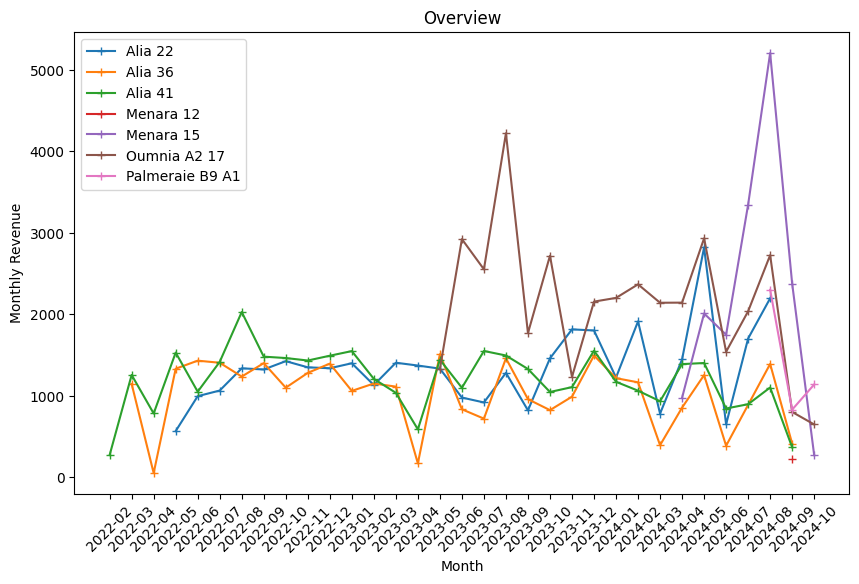

In [32]:
columns = ['Alia 22', 'Alia 36', 'Alia 41', 'Menara 12', 'Menara 15', 'Oumnia A2 17', 'Palmeraie B9 A1']
plt.figure(figsize=(10, 6))
for col in columns:
    plt.plot(df2[df2[col] != 0][col], label=col, marker='+');

plt.xticks(ticks=range(len(df2)), labels=df2['Month'].values, rotation=45);
plt.xlabel('Month');  # Replace with your appropriate x-axis label
plt.ylabel('Monthly Revenue');  # Replace with your appropriate y-axis label
plt.title('Overview');  # Replace with your title
plt.legend();


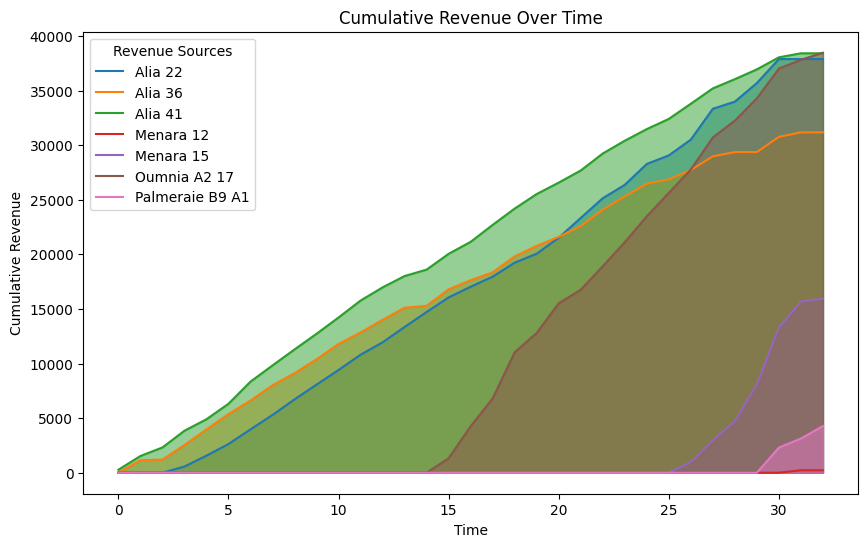

In [41]:
import matplotlib.pyplot as plt

# Calculate cumulative sum for each column
df_cumsum = df2[['Alia 22', 'Alia 36', 'Alia 41', 'Menara 12', 'Menara 15', 
                 'Oumnia A2 17', 'Palmeraie B9 A1']].cumsum()

# Set up a color map with enough distinct colors
colors = plt.cm.tab10(range(len(df_cumsum.columns)))

# Plot each series and fill the area under each curve
plt.figure(figsize=(10, 6))
for idx, column in enumerate(df_cumsum.columns):
    plt.plot(df_cumsum.index, df_cumsum[column], label=column, color=colors[idx])  # Line
    plt.fill_between(df_cumsum.index, df_cumsum[column], color=colors[idx], alpha=0.5)  # Surface

# Adding labels and title
plt.xlabel('Time')  # Replace with your x-axis label
plt.ylabel('Cumulative Revenue')  # Replace with your y-axis label
plt.title('Cumulative Revenue Over Time')

# Show the legend
plt.legend(title="Revenue Sources")

# Display the plot
plt.show()
